In [57]:
import seaborn as sns
from datetime import datetime 
import matplotlib.pyplot as plt

In [1]:
# user_spec과 loan_result의 일부 열을 join하여 user의 application별 신청 여부를 가져온다.
import pandas as pd
loan_result = pd.read_csv("loan_result.csv")
user_spec = pd.read_csv("user_spec.csv")[['application_id','user_id']]
user_app=loan_result.groupby('application_id').max()[['is_applied']].join(user_spec,how="outer")

In [ ]:
# user의 정보를 가져온다.
userlist = pd.read_csv('userlist.csv',index_col=0)

In [31]:
# is_applied 정보가 포함된 log에사 대출 조회와 관련된 event만 가져와, (대출 조회 성공은 1, 중도 종료는 0)으로 mapping한다.
alllog = pd.read_csv('alllog.csv')
alllog['newevent'] = alllog[
    alllog['event'].isin(
        ['ViewLoanApply','StartLoanApply',
        'CompleteIDCertification','IsApplied',
        'NotApplied']
    )
]['event'].map(
    {'ViewLoanApply':0,'StartLoanApply':0,
     'CompleteIDCertification':0,'IsApplied':1,
     'NotApplied':1}
)
alllog = alllog.dropna()[['user_id','newevent']]

In [ ]:
# 대출성사비율 파생변수 생성하여 전체 데이터에 feature로 추가
app_rate = pd.DataFrame()
app_rate['app_rate'] = user_app.groupby('user_id').mean()['is_applied']
app_rate['user_id'] = user_app.groupby('user_id').count().index
app_rate = app_rate.reset_index(drop = True)
fulllist = pd.merge(userlist,app_rate,on ='user_id')

In [32]:
# 조회완료비율 파생변수 생성하여 전체 데이터에 feature로 추가
finishrate = pd.DataFrame()
finishrate['finishrate'] = (alllog.groupby('user_id').count()['newevent']-alllog.groupby('user_id').sum()['newevent'])/(alllog.groupby('user_id').count()['newevent']-2)
finishrate['user_id'] = alllog.groupby('user_id').count().index
finishrate = finishrate.reset_index(drop = True)
fulllist = pd.merge(fulllist,finishrate,on ='user_id')

In [ ]:
#종원이 코드 여기에 넣기

In [34]:
#sessan(종원이가 보낸 파일) 사용

sessan = pd.read_csv('sessan.csv')
sessan['certificate'] =sessan['certificate'].apply(lambda x: 1 if x > 0 else 0)
fulllist = pd.merge(fulllist,sessan[['user_id','sessionnum','pyunggyuntime','certificate']],on ='user_id')
fulllist = fulllist.dropna()

In [49]:
# 나이, 근속연수 열 추가 등 전처리
fulllist['age'] = pd.to_datetime(fulllist['birth_year']).apply(lambda x: 2022 - x.year)
fulllist['desired_amount'] = fulllist['desired_amount'].apply(lambda t: np.log10(t+1))
fulllist['yearly_income'] = fulllist['yearly_income'].apply(lambda t: np.log10(t+1))
fulllist['existing_loan_amt'] = fulllist['existing_loan_amt'].apply(lambda t: np.log10(t+1))
fulllist['seniority'] = pd.to_datetime(fulllist['company_enter_month']).apply(lambda x: 2022 - x.year)

In [22]:
import numpy as np

def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

In [23]:
gini(fulllist['finishrate'])

0.3985238015193171

<AxesSubplot:>

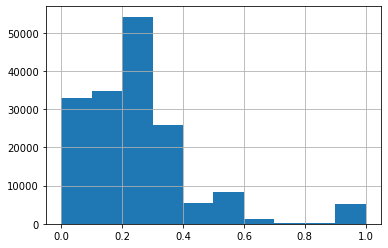

In [24]:
fulllist['finishrate'].hist()

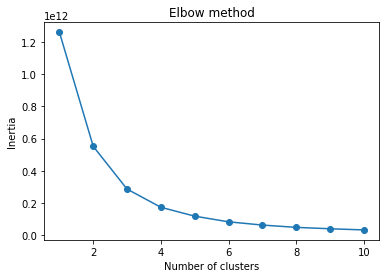

In [58]:
from sklearn.cluster import KMeans
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(fulllist.drop(
        [
            'user_id','birth_year','company_enter_month',
            'income_type','employment_type',
            'houseown_type','purpose'
        ],
        axis=1
    ))
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [59]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(fulllist.drop(
    ['user_id','birth_year','company_enter_month',
     'income_type','employment_type',
     'houseown_type','purpose'],
    axis=1
))

KMeans(n_clusters=3)

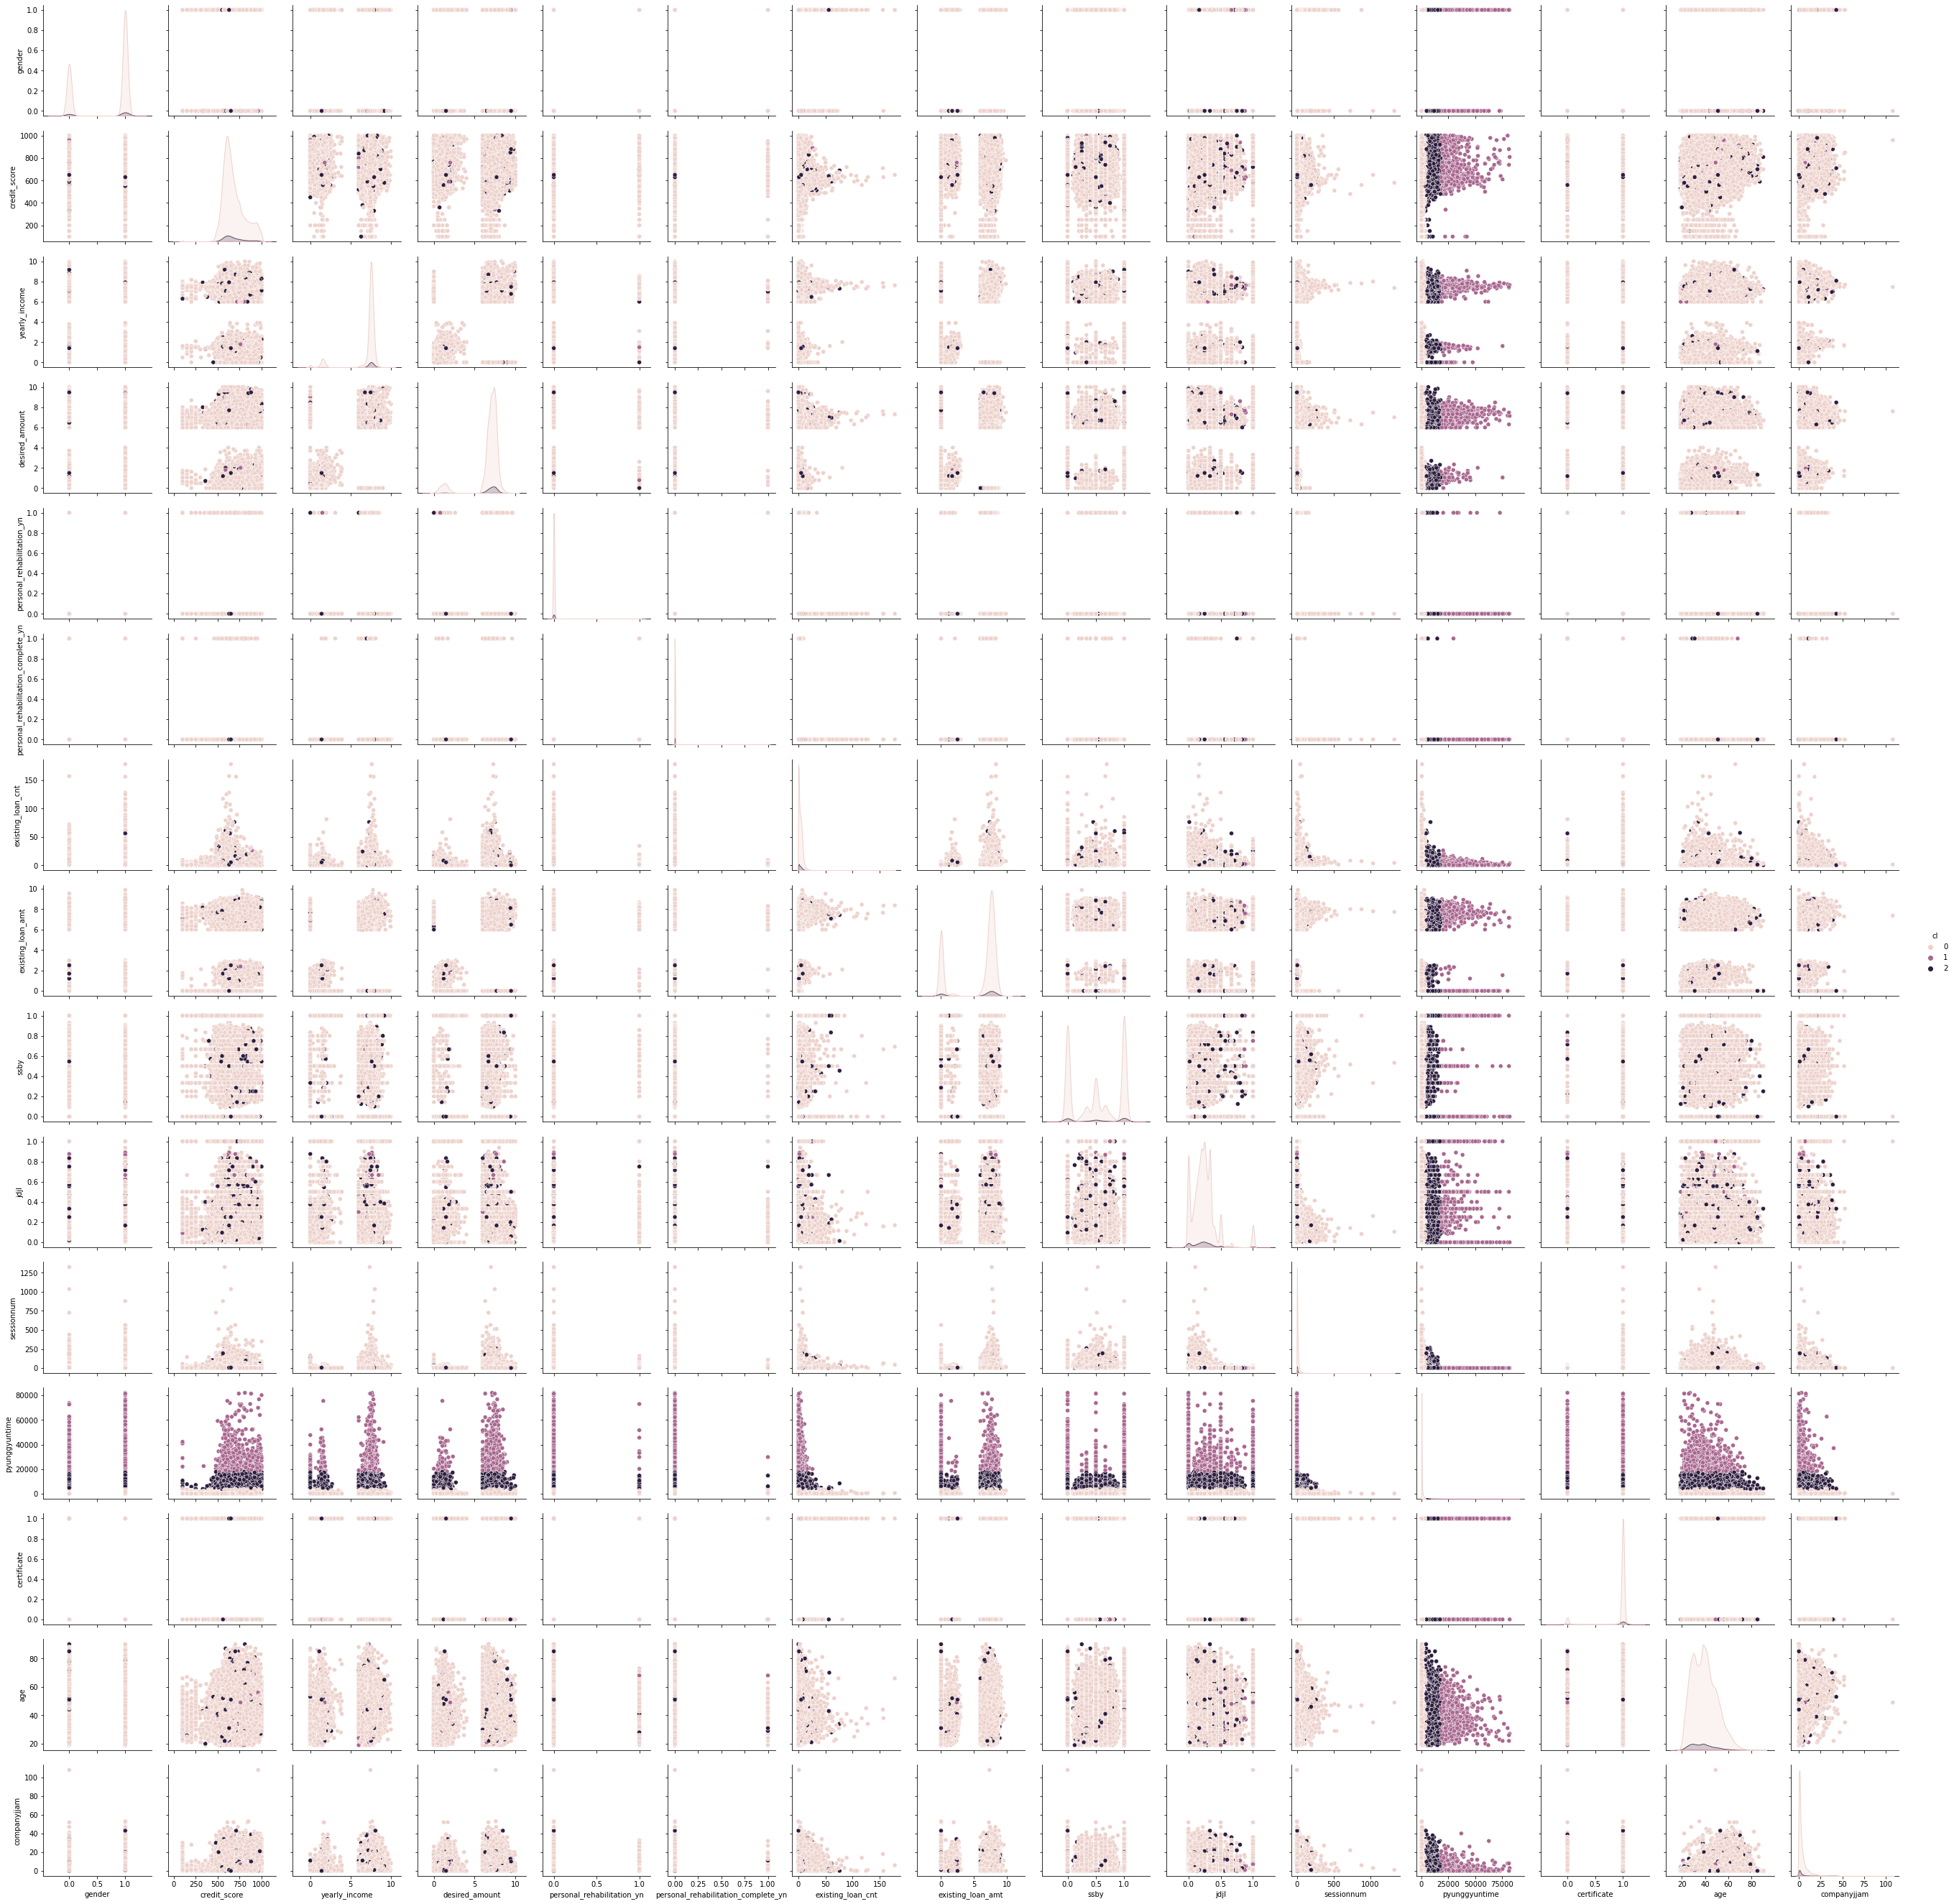

In [63]:
sns.pairplot(klist,hue='cl')